
 Copyright 2022
 ASTRON (Netherlands Institute for Radio Astronomy) <http://www.astron.nl/>
 P.O.Box 2, 7990 AA Dwingeloo, The Netherlands

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.

--------------------------------------------------------------------------------
 Author: R vd Walle
 
 Purpose: Simulate the principle of the DISTURB2 filterbank firmware
 
 Description: Generate an input signal containing 2 sine waves with frequencies
 at the center frequency of subband 50 and subband 50.5. This demonstrates how
 the two FFT results from a normal FFT and the FFT of a frequency shifted (by
 half a subband) input show that both are not ideal. Thereafter, the two FFT 
 results are combined to generate the ideal output. This is done by first
 performing FFT's on each subband using 16 samples to create channels. Then 
 the channels are combined by using the middle 8 channels of each subband
 interleaving the channels from the normal FFT and the shifted FFT.


In [1]:

# System imports
import numpy as np
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from tools import *
from common import *


In [2]:

# Constants
N_sub        = 512
N_wg_samples = 4 * N_sub
sample_freq  = 200000000
shift_freq   = 0.5 * ((sample_freq/2 ) / N_sub) # half a subband
N_sample     = 2 * N_sub
N_blocks     = 16 # Also number of channels per subband
wg_sub       = 50.5
wg_sub_n     = 50
wg_freq      = wg_sub * ((sample_freq/2) / N_sub)
wg_freq_n    = wg_sub_n * ((sample_freq/2) / N_sub)
wg_ampl      = 1.0

# Frequency shifting signal
n_array   = np.arange(0, N_wg_samples, 1)
pow_array = [complex(0,1) * 2 * np.pi * (shift_freq / sample_freq) * n for n in n_array]
nof_rep   = ceil_div(N_blocks*N_sample, N_wg_samples)
exp_array = np.tile([np.exp(w) for w in pow_array], nof_rep) # y[n] = e^(j * 2Pi * (f/Fs) * n)

#rotate exp_array
#rot = N_wg_samples // 2
#print(exp_array)
#exp_array = np.array(list(exp_array[rot:]) + list(exp_array[:rot]))
#print(exp_array)

# At what intervals time points are sampled
samplingInterval = 1 / sample_freq;

# Begin time period of the signals
beginTime        = 0;

# End time period of the signals
endTime          = N_blocks * N_sample * samplingInterval; 

# Time points
time             = np.arange(beginTime, endTime, samplingInterval);

# Create input signal
amplitude = np.sin(2*np.pi*wg_freq*time) + np.sin(2*np.pi*wg_freq_n*time) 
spr_blocks = [amplitude[i * N_sample : (i+1) * N_sample] for i in range(N_blocks)]

# Shifted signal
amplitude_shft = amplitude * exp_array[0:len(time)]
spc_blocks = [amplitude_shft[i * N_sample : (i+1) * N_sample] for i in range(N_blocks)]

# Bin indices for input/shifted signal
freq = np.fft.fftfreq(np.arange(N_sample).shape[-1], samplingInterval)
subbands = [f/(shift_freq*2) for f in freq]

# Channel indices.
freq_ch = np.fft.fftfreq(np.arange(N_blocks*N_sample).shape[-1], samplingInterval)
channels = [f/(shift_freq*2) for f in freq_ch]
channels = channels[0:len(channels) // 2:] # Only positive part is used.

In [3]:
# FFT of every block
spr = [np.fft.fft(spr_block) for spr_block in spr_blocks]
# spr contains [blocks (N_blocks)][subbands (N_sample)]
# We only need the positive part of the FFT and we need it in order [subbands][blocks] for channels
sprT = [x[:N_sub] for x in spr] # Take positive part, like we receive from the FPGA.
sprT = np.transpose(np.array(sprT)) # transpose
# FFT of every subband, creating channels.
spr_ch = np.array([np.fft.fftshift(np.fft.fft(band)) for band in sprT]) 

# The same for the shifted subbands
spc = [np.fft.fft(spc_block) for spc_block in spc_blocks]
spcT = [x[:N_sub] for x in spc]
spcT = np.transpose(np.array(spcT))
spc_ch = np.array([np.fft.fftshift(np.fft.fft(band)) for band in spcT])

# Combine the channels.
combined = [0] * N_blocks * N_sub
for i in range(N_sub):
    # for N_blocks = number of channels per subband = 16
    #0:8 = spr_ch[0][4:12]
    #8:16 = spc_ch[0][4:12]
    #16:24 = spr_ch[1][4:12]
    #24:32 = spc_ch[1][4:12]
    # ...
    n_ch = N_blocks // 2

    combined[ 2 * i      * n_ch :  (2 * i + 1) * n_ch] = spc_ch[i][n_ch // 2 : n_ch + (n_ch // 2)]
    combined[(2 * i + 1) * n_ch :  (2 * i + 2) * n_ch] = spr_ch[i][n_ch // 2 : n_ch + (n_ch // 2)]

# shift 3/4 subband to 0
combined = np.array(combined)
combined = combined[(3 * N_blocks // 4):]
combined = np.append(combined, spc_ch[N_sub-1][N_blocks // 4:])

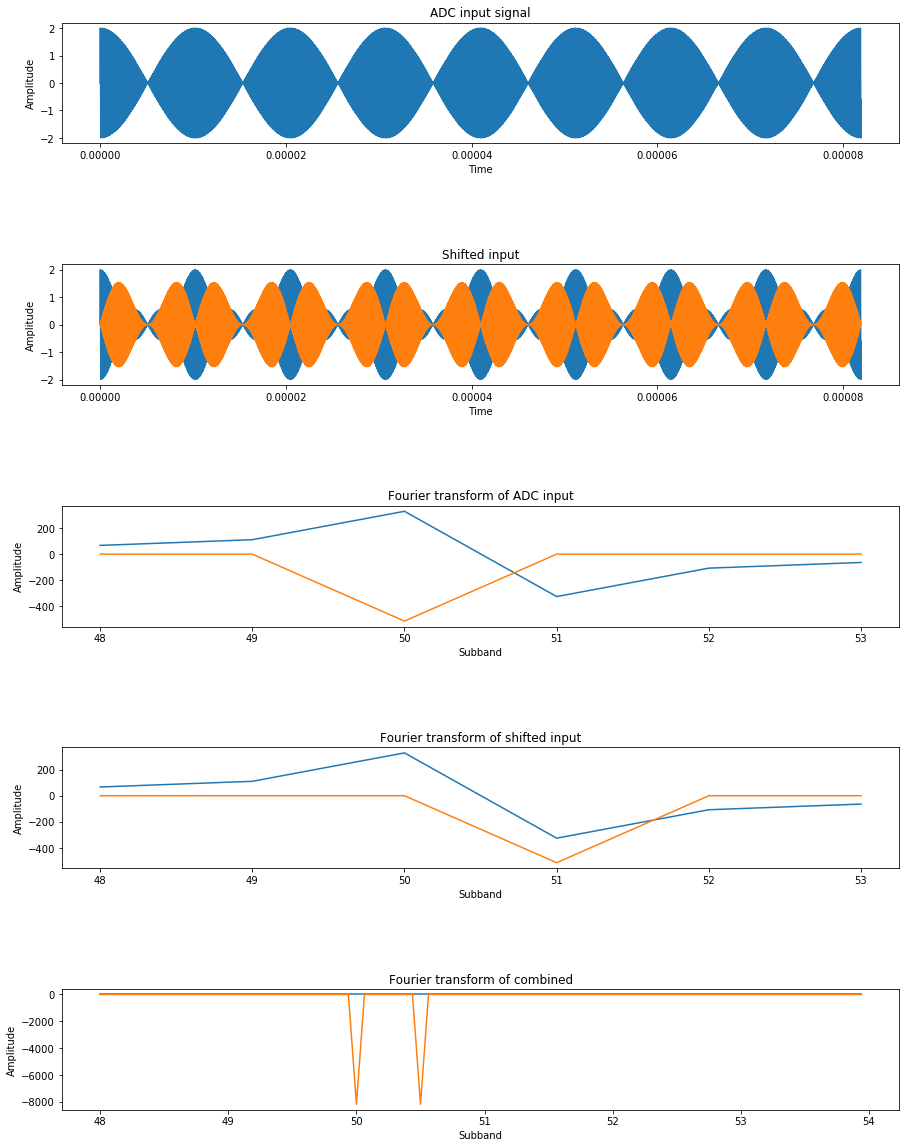

In [6]:
# Create subplot
figure, axis = plt.subplots(5, 1, figsize=(15,20))
plt.subplots_adjust(hspace=1)
windowRange = [48, 54]

# Time domain representation of the input signal
axis[0].set_title('ADC input signal')
axis[0].plot(time, amplitude)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')


# Time domain representation of the frequency shifted signal
axis[1].set_title('Shifted input')
axis[1].plot(time, amplitude_shft.real, time, amplitude_shft.imag)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')


# Frequency domain representation of input signal
x = subbands[windowRange[0]:windowRange[1]]
y = spr[0][windowRange[0]:windowRange[1]]
axis[2].set_title('Fourier transform of ADC input')
axis[2].plot(x, y.real, x, y.imag)
axis[2].set_xlabel('Subband')
axis[2].set_ylabel('Amplitude')

# Frequency domain representation of frequency shifted signal
x = subbands[windowRange[0]:windowRange[1]]
y = spc[0][windowRange[0]:windowRange[1]]
axis[3].set_title('Fourier transform of shifted input')
axis[3].plot(x, y.real, x, y.imag)
axis[3].set_xlabel('Subband')
axis[3].set_ylabel('Amplitude')

x = channels[N_blocks * windowRange[0]:N_blocks * windowRange[1]]
y = combined[N_blocks * windowRange[0]:N_blocks * windowRange[1]]
# Frequency domain representation of combined channels
axis[4].set_title('Fourier transform of combined')
axis[4].plot(x, y.real, x, y.imag)
axis[4].set_xlabel('Subband')
axis[4].set_ylabel('Amplitude')

plt.show()